<a href="https://colab.research.google.com/github/DmitriyKhodykin/USFinancials/blob/main/get_target.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ПРОЕКТ: US Financials

Пакет для получения таргета

## Пространство имен

In [ ]:
# Импортры

## Постоянное хранилище данных
from google.colab import drive

## Время и дата
import datetime

## Таблицы и вычисления
import numpy as np
import pandas as pd

## Визуализация данных
import seaborn as sns
from seaborn import heatmap
import matplotlib.pyplot as plt

## Утилиты
import warnings

In [ ]:
# Хранение и загрузка данных
drive.mount('/content/drive')
work_dir = '/content/drive/My Drive/Models/USFinancials'
data_dir = '/content/drive/My Drive/Data/USFinancials'

Mounted at /content/drive


## Часто используемый код

In [ ]:
def cols_to_datetime(df: pd.DataFrame, cols: list) ->  pd.DataFrame:
    """Для преобразования столбцов датафрейма к формату дата-время
    по списку передаваемых в функцию наименований столбцов
    """
    for i in cols:
        df[i] = pd.to_datetime(df[i])
    return df

In [ ]:
def show_filing_period(df: pd.DataFrame, feature: str):
    """Распределение отклонений по выпуску отчетности
    """
    df_copy = df.copy()
    df_copy['delta'] = df_copy[feature] - df_copy['date']
    df_copy['delta'] = df_copy['delta'].dt.days
    sns.set_theme()
    warnings.filterwarnings('ignore')
    return sns.distplot(df_copy[df_copy['delta'] < 100]['delta'])

## Загрузка данных

### Stock

In [ ]:
# Котировки акций, очищенные от рынного шума
# т.е. котировок акций к котировке SNP500
stock = pd.read_parquet(f'{work_dir}/US_stocks_hist_data.parquet')

In [ ]:
stock['date'] = stock.index
stock.tail(3)

ticker,A,AA,AAALF,AAALY,AABB,AABVF,AACAF,AACAY,AACG,AACQ,AACQU,AACQW,AACS,AACTF,AAEEF,AAGC,AAGEF,AAGFF,AAGH,AAGIY,AAGRY,AAIC,AAIGF,AAIIQ,AALBF,AAMAF,AAMC,AAME,AAMMF,AAMTF,AAN,AANNF,AAOI,AAON,AAP,AAPJ,AAPL,AAPT,AASL,AASP,...,ZRSEF,ZRVT,ZS,ZSAN,ZSHGY,ZSTN,ZSYC,ZTCOF,ZTCOY,ZTLLF,ZTMUF,ZTNO,ZTO,ZTS,ZTSTF,ZULU,ZUMRF,ZUMZ,ZUO,ZURVY,ZVLO,ZVO,ZVTK,ZVZZT,ZWBC,ZWRKU,ZWZZT,ZXAIY,ZXZZT,ZYJT,ZYME,ZYNE,ZYQG,ZYRX,ZYXI,ZZHGF,ZZLL,ZZZOF,^GSPC,date
2021-03-18,1.015332,0.995270,1.014761,1.014761,1.067129,0.871903,1.014761,0.994941,1.045195,1.015727,1.008544,NaN,1.264761,0.969306,1.014761,1.10567,1.014761,1.010953,1.014761,1.013177,1.014761,0.990606,1.010830,1.014761,1.014761,0.923851,1.036351,1.080488,1.016306,1.014339,0.997415,1.014761,0.96915,1.018757,1.025877,1.258646,0.980855,0.848094,1.014761,1.014761,...,0.716208,1.013991,0.976343,0.946733,1.014761,1.014761,1.014761,1.011001,0.977261,0.922351,1.014761,1.014761,0.908636,0.990748,1.014761,1.014761,1.014761,1.009217,1.007328,1.009368,1.014761,1.023819,1.176130,NaN,1.014761,1.013770,1.014761,0.871903,NaN,1.014761,0.981377,0.909205,1.014761,1.014761,0.964454,1.014761,1.014761,1.339264,1.0,2021-03-18
2021-03-19,0.999241,0.995925,0.997528,0.997528,1.155067,0.946694,0.997528,0.996149,1.113562,0.992702,0.990379,NaN,1.147528,0.991179,0.997528,1.31975,0.997528,1.007464,0.973959,1.005258,0.997528,0.977726,0.980164,0.544451,0.997528,1.013153,0.901136,1.253034,1.046910,1.083501,0.989853,0.997528,1.01067,0.990527,1.009883,0.991910,0.993048,0.997528,0.997528,0.790631,...,1.013968,0.997528,1.016326,1.034024,0.997528,1.088437,0.997528,1.018282,0.997528,0.997528,0.997528,0.997528,0.968016,1.002120,0.997528,0.997528,0.997528,1.030750,1.025438,1.004128,0.412494,1.051388,0.936651,NaN,0.997528,0.988608,0.997528,0.997528,NaN,0.997528,1.096429,1.096907,0.997528,1.747528,1.037580,0.997528,0.997528,0.997528,1.0,2021-03-19
2021-03-20,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.000000,1.000000,1.000000,1.000000,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,2021-03-20


### Фин. показатели

In [ ]:
balance_df = pd.read_csv(f'{data_dir}/balance_df.csv').iloc[:,2:].copy()
# Ключ для сведения в общий фрейм данных
balance_df['key'] = balance_df['date'] + balance_df['name']

In [ ]:
balance_df.head(3)

,date,filing_date,currency_symbol,totalAssets,intangibleAssets,earningAssets,otherCurrentAssets,totalLiab,totalStockholderEquity,deferredLongTermLiab,otherCurrentLiab,commonStock,retainedEarnings,otherLiab,goodWill,otherAssets,cash,totalCurrentLiabilities,shortTermDebt,shortLongTermDebt,shortLongTermDebtTotal,otherStockholderEquity,propertyPlantEquipment,totalCurrentAssets,longTermInvestments,netTangibleAssets,shortTermInvestments,netReceivables,longTermDebt,inventory,accountsPayable,totalPermanentEquity,noncontrollingInterestInConsolidatedEntity,temporaryEquityRedeemableNoncontrollingInterests,accumulatedOtherComprehensiveIncome,additionalPaidInCapital,commonStockTotalEquity,preferredStockTotalEquity,retainedEarningsTotalEquity,treasuryStock,accumulatedAmortization,nonCurrrentAssetsOther,deferredLongTermAssetCharges,nonCurrentAssetsTotal,capitalLeaseObligations,longTermDebtTotal,nonCurrentLiabilitiesOther,nonCurrentLiabilitiesTotal,negativeGoodwill,warrants,preferredStockRedeemable,capitalSurpluse,liabilitiesAndStockholdersEquity,cashAndShortTermInvestments,propertyPlantAndEquipmentGross,accumulatedDepreciation,commonStockSharesOutstanding,name,alter_filing,key
0,2020-09-30,2020-11-12,USD,19926000.0,NaN,NaN,1764000.0,8837000.0,11089000.0,NaN,638000.0,2000.0,-215071000.0,432000.0,NaN,82000.0,9200000.0,3349000.0,664000.0,664000.0,NaN,NaN,2507000.0,16244000.0,893000.0,11089000.0,NaN,689000.0,5056000.0,4591000.0,3117000.0,NaN,NaN,NaN,NaN,NaN,2000.0,NaN,-215071000.0,NaN,NaN,282000.0,NaN,3682000.0,203000.0,5056000.0,432000.0,5056000.0,NaN,NaN,NaN,226158000.0,19926000.0,9200000.0,NaN,NaN,21653782.0,VIVE,2020-11-12,2020-09-30VIVE
1,2020-06-30,2020-08-13,USD,20532000.0,NaN,NaN,1921000.0,9905000.0,10627000.0,NaN,1066000.0,2000.0,-211336000.0,222000.0,NaN,109000.0,8500000.0,4651000.0,5584000.0,559000.0,NaN,NaN,3120000.0,16355000.0,948000.0,10627000.0,NaN,1017000.0,5025000.0,4917000.0,1257000.0,NaN,NaN,NaN,NaN,NaN,2000.0,NaN,-211336000.0,NaN,NaN,376000.0,NaN,4177000.0,265000.0,NaN,229000.0,5254000.0,NaN,NaN,NaN,221961000.0,20532000.0,8500000.0,NaN,NaN,15734058.0,VIVE,2020-08-13,2020-06-30VIVE
2,2020-03-31,2020-05-14,USD,21432000.0,NaN,NaN,2204000.0,8881000.0,12551000.0,NaN,703000.0,1000.0,-204221000.0,127000.0,NaN,109000.0,9042000.0,4585000.0,NaN,NaN,NaN,NaN,3305000.0,16984000.0,1034000.0,12551000.0,NaN,1279000.0,4110000.0,4459000.0,2262000.0,NaN,NaN,NaN,NaN,NaN,1000.0,NaN,-204221000.0,NaN,NaN,441000.0,NaN,4448000.0,278000.0,4110000.0,186000.0,4296000.0,NaN,NaN,NaN,216771000.0,21432000.0,9042000.0,NaN,NaN,9000000.0,VIVE,2020-05-14,2020-03-31VIVE


In [ ]:
cashe_df = pd.read_csv(f'{data_dir}/cashe_df.csv').iloc[:,2:].copy()
# Ключ для сведения в общий фрейм данных
cashe_df['key'] = cashe_df['date'] + cashe_df['name']

In [ ]:
cashe_df.head(3)

,date,filing_date,currency_symbol,investments,changeToLiabilities,totalCashflowsFromInvestingActivities,netBorrowings,totalCashFromFinancingActivities,changeToOperatingActivities,netIncome,changeInCash,beginPeriodCashFlow,endPeriodCashFlow,totalCashFromOperatingActivities,depreciation,otherCashflowsFromInvestingActivities,dividendsPaid,changeToInventory,changeToAccountReceivables,salePurchaseOfStock,otherCashflowsFromFinancingActivities,changeToNetincome,capitalExpenditures,changeReceivables,cashFlowsOtherOperating,exchangeRateChanges,cashAndCashEquivalentsChanges,name,alter_filing,key
0,2020-09-30,2020-11-12,USD,-111000.0,-1138000.0,-111000.0,NaN,3558000.0,-392000.0,-3735000.0,700000.0,8500000.0,9200000.0,-2747000.0,314000.0,NaN,NaN,455000.0,222000.0,3565000.0,-7000.0,953000.0,111000.0,222000.0,182000.0,NaN,700000.0,VIVE,2020-11-12,2020-09-30VIVE
1,2020-06-30,2020-08-13,USD,-131000.0,-388000.0,-131000.0,1343000.0,4042000.0,900000.0,-7115000.0,-542000.0,9042000.0,8500000.0,-4453000.0,328000.0,NaN,NaN,-535000.0,107000.0,3025000.0,-326000.0,2867000.0,131000.0,107000.0,283000.0,NaN,-542000.0,VIVE,2020-08-13,2020-06-30VIVE
2,2020-03-31,2020-05-14,USD,-161000.0,-2040000.0,-161000.0,1343000.0,1631000.0,-2034000.0,-6310000.0,-4266000.0,13308000.0,9042000.0,-5736000.0,323000.0,NaN,NaN,313000.0,220000.0,1631000.0,-30000.0,1093000.0,161000.0,220000.0,665000.0,NaN,-4266000.0,VIVE,2020-05-14,2020-03-31VIVE


In [ ]:
income_df = pd.read_csv(f'{data_dir}/income_df.csv').iloc[:,2:].copy()
# Ключ для сведения в общий фрейм данных
income_df['key'] = income_df['date'] + income_df['name']

In [ ]:
income_df.head(3)

,date,filing_date,currency_symbol,researchDevelopment,effectOfAccountingCharges,incomeBeforeTax,minorityInterest,netIncome,sellingGeneralAdministrative,grossProfit,ebit,nonOperatingIncomeNetOther,operatingIncome,otherOperatingExpenses,interestExpense,taxProvision,interestIncome,netInterestIncome,extraordinaryItems,nonRecurring,otherItems,incomeTaxExpense,totalRevenue,totalOperatingExpenses,costOfRevenue,totalOtherIncomeExpenseNet,discontinuedOperations,netIncomeFromContinuingOps,netIncomeApplicableToCommonShares,preferredStockAndOtherAdjustments,name,alter_filing,key
0,2020-09-30,2020-11-12,USD,884000.0,NaN,-3680000.0,NaN,-3735000.0,2761000.0,241000.0,-3133000.0,-96000.0,-3404000.0,NaN,235000.0,NaN,NaN,-235000.0,NaN,NaN,NaN,NaN,1524000.0,3645000.0,1283000.0,-41000.0,NaN,-3680000.0,-4788000.0,1053000.0,VIVE,2020-11-12,2020-09-30VIVE
1,2020-06-30,2020-08-13,USD,1224000.0,NaN,-7029000.0,NaN,-7115000.0,3350000.0,-367000.0,-4640000.0,-1951000.0,-4941000.0,NaN,223000.0,NaN,NaN,-223000.0,NaN,NaN,NaN,NaN,704000.0,5645000.0,1071000.0,-1865000.0,NaN,-7029000.0,-8136000.0,1021000.0,VIVE,2020-08-13,2020-06-30VIVE
2,2020-03-31,2020-05-14,USD,1637000.0,NaN,-6128000.0,NaN,-6310000.0,4365000.0,175000.0,-5590000.0,-273000.0,-5827000.0,NaN,210000.0,NaN,-210000.0,-210000.0,NaN,NaN,NaN,NaN,1304000.0,7131000.0,1129000.0,-91000.0,NaN,-6128000.0,-7299000.0,989000.0,VIVE,2020-05-14,2020-03-31VIVE


## Сведение данных

Далее, сведем финансовые отчеты в единый финансовый датафрейм `fin_df`. Это позволит проще работать со столбцами признаков, сопоставляя их размерность с таргетом в будущем

In [ ]:
# Объединим отчеты по ключу: (date + ticker)
fin_df = income_df.merge(
    balance_df, how='inner', on='key'
).merge(
    cashe_df, how='inner', on='key'
)

In [ ]:
fin_df.head(3)

,date_x,filing_date_x,currency_symbol_x,researchDevelopment,effectOfAccountingCharges,incomeBeforeTax,minorityInterest,netIncome_x,sellingGeneralAdministrative,grossProfit,ebit,nonOperatingIncomeNetOther,operatingIncome,otherOperatingExpenses,interestExpense,taxProvision,interestIncome,netInterestIncome,extraordinaryItems,nonRecurring,otherItems,incomeTaxExpense,totalRevenue,totalOperatingExpenses,costOfRevenue,totalOtherIncomeExpenseNet,discontinuedOperations,netIncomeFromContinuingOps,netIncomeApplicableToCommonShares,preferredStockAndOtherAdjustments,name_x,alter_filing_x,key,date_y,filing_date_y,currency_symbol_y,totalAssets,intangibleAssets,earningAssets,otherCurrentAssets,...,negativeGoodwill,warrants,preferredStockRedeemable,capitalSurpluse,liabilitiesAndStockholdersEquity,cashAndShortTermInvestments,propertyPlantAndEquipmentGross,accumulatedDepreciation,commonStockSharesOutstanding,name_y,alter_filing_y,date,filing_date,currency_symbol,investments,changeToLiabilities,totalCashflowsFromInvestingActivities,netBorrowings,totalCashFromFinancingActivities,changeToOperatingActivities,netIncome_y,changeInCash,beginPeriodCashFlow,endPeriodCashFlow,totalCashFromOperatingActivities,depreciation,otherCashflowsFromInvestingActivities,dividendsPaid,changeToInventory,changeToAccountReceivables,salePurchaseOfStock,otherCashflowsFromFinancingActivities,changeToNetincome,capitalExpenditures,changeReceivables,cashFlowsOtherOperating,exchangeRateChanges,cashAndCashEquivalentsChanges,name,alter_filing
0,2020-09-30,2020-11-12,USD,884000.0,NaN,-3680000.0,NaN,-3735000.0,2761000.0,241000.0,-3133000.0,-96000.0,-3404000.0,NaN,235000.0,NaN,NaN,-235000.0,NaN,NaN,NaN,NaN,1524000.0,3645000.0,1283000.0,-41000.0,NaN,-3680000.0,-4788000.0,1053000.0,VIVE,2020-11-12,2020-09-30VIVE,2020-09-30,2020-11-12,USD,19926000.0,NaN,NaN,1764000.0,...,NaN,NaN,NaN,226158000.0,19926000.0,9200000.0,NaN,NaN,21653782.0,VIVE,2020-11-12,2020-09-30,2020-11-12,USD,-111000.0,-1138000.0,-111000.0,NaN,3558000.0,-392000.0,-3735000.0,700000.0,8500000.0,9200000.0,-2747000.0,314000.0,NaN,NaN,455000.0,222000.0,3565000.0,-7000.0,953000.0,111000.0,222000.0,182000.0,NaN,700000.0,VIVE,2020-11-12
1,2020-06-30,2020-08-13,USD,1224000.0,NaN,-7029000.0,NaN,-7115000.0,3350000.0,-367000.0,-4640000.0,-1951000.0,-4941000.0,NaN,223000.0,NaN,NaN,-223000.0,NaN,NaN,NaN,NaN,704000.0,5645000.0,1071000.0,-1865000.0,NaN,-7029000.0,-8136000.0,1021000.0,VIVE,2020-08-13,2020-06-30VIVE,2020-06-30,2020-08-13,USD,20532000.0,NaN,NaN,1921000.0,...,NaN,NaN,NaN,221961000.0,20532000.0,8500000.0,NaN,NaN,15734058.0,VIVE,2020-08-13,2020-06-30,2020-08-13,USD,-131000.0,-388000.0,-131000.0,1343000.0,4042000.0,900000.0,-7115000.0,-542000.0,9042000.0,8500000.0,-4453000.0,328000.0,NaN,NaN,-535000.0,107000.0,3025000.0,-326000.0,2867000.0,131000.0,107000.0,283000.0,NaN,-542000.0,VIVE,2020-08-13
2,2020-03-31,2020-05-14,USD,1637000.0,NaN,-6128000.0,NaN,-6310000.0,4365000.0,175000.0,-5590000.0,-273000.0,-5827000.0,NaN,210000.0,NaN,-210000.0,-210000.0,NaN,NaN,NaN,NaN,1304000.0,7131000.0,1129000.0,-91000.0,NaN,-6128000.0,-7299000.0,989000.0,VIVE,2020-05-14,2020-03-31VIVE,2020-03-31,2020-05-14,USD,21432000.0,NaN,NaN,2204000.0,...,NaN,NaN,NaN,216771000.0,21432000.0,9042000.0,NaN,NaN,9000000.0,VIVE,2020-05-14,2020-03-31,2020-05-14,USD,-161000.0,-2040000.0,-161000.0,1343000.0,1631000.0,-2034000.0,-6310000.0,-4266000.0,13308000.0,9042000.0,-5736000.0,323000.0,NaN,NaN,313000.0,220000.0,1631000.0,-30000.0,1093000.0,161000.0,220000.0,665000.0,NaN,-4266000.0,VIVE,2020-05-14


In [ ]:
# Преобразование object to datetime для работы с датами
fin_df = cols_to_datetime(
    fin_df, [
             'filing_date',
             'filing_date_x',
             'filing_date_y'         
            ]
)

In [ ]:
def max_dt(row):
    """Возвращает максимальный filing_date
    из трех финансовых отчетов для заполнения пробелов признака
    """
    tmp_list = [
        row['filing_date'],
        row['filing_date_x'],
        row['filing_date_y']
    ]

    for i in tmp_list:
        if type(i) == pd._libs.tslibs.timestamps.Timestamp:
            return i

In [ ]:
# Заполним filing_date из трех фин.отчетов
fin_df['full_filing_date'] = fin_df.apply(max_dt, axis=1)

In [ ]:
# Посмотрим на результат
fin_df[['filing_date_x', 'filing_date_y', 
        'filing_date', 'full_filing_date']]

,filing_date_x,filing_date_y,filing_date,full_filing_date
0,2020-11-12,2020-11-12,2020-11-12,2020-11-12
1,2020-08-13,2020-08-13,2020-08-13,2020-08-13
2,2020-05-14,2020-05-14,2020-05-14,2020-05-14
3,NaT,2020-03-19,NaT,2020-03-19
4,NaT,NaT,2019-11-07,2019-11-07
...,...,...,...,...
239378,NaT,NaT,NaT,NaT
239379,NaT,NaT,NaT,NaT
239380,NaT,NaT,NaT,NaT
239381,NaT,NaT,NaT,NaT


Как видно, мы "выжали" максимум имеющейся информации по признаку в столбец `full_filing_date`

In [ ]:
# Удалим задублировавшиеся при объединении столбцы
fin_df = fin_df.drop(
    [
     'date_x', 'date_y', 'filing_date_x', 'filing_date_y', 'name_x', 
     'alter_filing_x', 'alter_filing_y', 'currency_symbol_x', 'name_y',
     'currency_symbol_y'
    ], 
    axis=1
)

In [ ]:
fin_df.head(3)

,researchDevelopment,effectOfAccountingCharges,incomeBeforeTax,minorityInterest,netIncome_x,sellingGeneralAdministrative,grossProfit,ebit,nonOperatingIncomeNetOther,operatingIncome,otherOperatingExpenses,interestExpense,taxProvision,interestIncome,netInterestIncome,extraordinaryItems,nonRecurring,otherItems,incomeTaxExpense,totalRevenue,totalOperatingExpenses,costOfRevenue,totalOtherIncomeExpenseNet,discontinuedOperations,netIncomeFromContinuingOps,netIncomeApplicableToCommonShares,preferredStockAndOtherAdjustments,key,totalAssets,intangibleAssets,earningAssets,otherCurrentAssets,totalLiab,totalStockholderEquity,deferredLongTermLiab,otherCurrentLiab,commonStock,retainedEarnings,otherLiab,goodWill,...,nonCurrentLiabilitiesTotal,negativeGoodwill,warrants,preferredStockRedeemable,capitalSurpluse,liabilitiesAndStockholdersEquity,cashAndShortTermInvestments,propertyPlantAndEquipmentGross,accumulatedDepreciation,commonStockSharesOutstanding,date,filing_date,currency_symbol,investments,changeToLiabilities,totalCashflowsFromInvestingActivities,netBorrowings,totalCashFromFinancingActivities,changeToOperatingActivities,netIncome_y,changeInCash,beginPeriodCashFlow,endPeriodCashFlow,totalCashFromOperatingActivities,depreciation,otherCashflowsFromInvestingActivities,dividendsPaid,changeToInventory,changeToAccountReceivables,salePurchaseOfStock,otherCashflowsFromFinancingActivities,changeToNetincome,capitalExpenditures,changeReceivables,cashFlowsOtherOperating,exchangeRateChanges,cashAndCashEquivalentsChanges,name,alter_filing,full_filing_date
0,884000.0,NaN,-3680000.0,NaN,-3735000.0,2761000.0,241000.0,-3133000.0,-96000.0,-3404000.0,NaN,235000.0,NaN,NaN,-235000.0,NaN,NaN,NaN,NaN,1524000.0,3645000.0,1283000.0,-41000.0,NaN,-3680000.0,-4788000.0,1053000.0,2020-09-30VIVE,19926000.0,NaN,NaN,1764000.0,8837000.0,11089000.0,NaN,638000.0,2000.0,-215071000.0,432000.0,NaN,...,5056000.0,NaN,NaN,NaN,226158000.0,19926000.0,9200000.0,NaN,NaN,21653782.0,2020-09-30,2020-11-12,USD,-111000.0,-1138000.0,-111000.0,NaN,3558000.0,-392000.0,-3735000.0,700000.0,8500000.0,9200000.0,-2747000.0,314000.0,NaN,NaN,455000.0,222000.0,3565000.0,-7000.0,953000.0,111000.0,222000.0,182000.0,NaN,700000.0,VIVE,2020-11-12,2020-11-12
1,1224000.0,NaN,-7029000.0,NaN,-7115000.0,3350000.0,-367000.0,-4640000.0,-1951000.0,-4941000.0,NaN,223000.0,NaN,NaN,-223000.0,NaN,NaN,NaN,NaN,704000.0,5645000.0,1071000.0,-1865000.0,NaN,-7029000.0,-8136000.0,1021000.0,2020-06-30VIVE,20532000.0,NaN,NaN,1921000.0,9905000.0,10627000.0,NaN,1066000.0,2000.0,-211336000.0,222000.0,NaN,...,5254000.0,NaN,NaN,NaN,221961000.0,20532000.0,8500000.0,NaN,NaN,15734058.0,2020-06-30,2020-08-13,USD,-131000.0,-388000.0,-131000.0,1343000.0,4042000.0,900000.0,-7115000.0,-542000.0,9042000.0,8500000.0,-4453000.0,328000.0,NaN,NaN,-535000.0,107000.0,3025000.0,-326000.0,2867000.0,131000.0,107000.0,283000.0,NaN,-542000.0,VIVE,2020-08-13,2020-08-13
2,1637000.0,NaN,-6128000.0,NaN,-6310000.0,4365000.0,175000.0,-5590000.0,-273000.0,-5827000.0,NaN,210000.0,NaN,-210000.0,-210000.0,NaN,NaN,NaN,NaN,1304000.0,7131000.0,1129000.0,-91000.0,NaN,-6128000.0,-7299000.0,989000.0,2020-03-31VIVE,21432000.0,NaN,NaN,2204000.0,8881000.0,12551000.0,NaN,703000.0,1000.0,-204221000.0,127000.0,NaN,...,4296000.0,NaN,NaN,NaN,216771000.0,21432000.0,9042000.0,NaN,NaN,9000000.0,2020-03-31,2020-05-14,USD,-161000.0,-2040000.0,-161000.0,1343000.0,1631000.0,-2034000.0,-6310000.0,-4266000.0,13308000.0,9042000.0,-5736000.0,323000.0,NaN,NaN,313000.0,220000.0,1631000.0,-30000.0,1093000.0,161000.0,220000.0,665000.0,NaN,-4266000.0,VIVE,2020-05-14,2020-05-14


In [ ]:
# Посчитаем количество пустых filing_date
fin_df['full_filing_date'].isna().sum()

106926

In [ ]:
# Сохраним промежуточный результат
fin_df.to_parquet(f'{data_dir}/fin_df.parquet')

In [ ]:
# Для первого приближения модели оставим те строки, где filing_date заполнен
fin_df_with_target = fin_df[
    fin_df['full_filing_date'] >= fin_df['full_filing_date'].min()
]

In [ ]:
# Количество пустых filing_date
fin_df_with_target['full_filing_date'].isna().sum()

0

Теперь с filing_date ассоциируем куммулятивное произведение котировки курса акции по эмитенту через различные промежутки времени.

In [ ]:
# Пример фильтрации периода
start = fin_df_with_target['full_filing_date'][0]
end = fin_df_with_target['full_filing_date'][0] + datetime.timedelta(7)

In [ ]:
start

Timestamp('2020-11-12 00:00:00')

In [ ]:
end

Timestamp('2020-11-19 00:00:00')

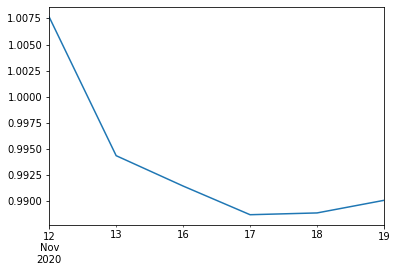

In [ ]:
# График изменения накопленного эффекта за неделю
stock[
      (stock['date'] >= start) &
      (stock['date'] <= end)
]['AAPL'].cumprod().plot();

In [ ]:
# Числовое выражение накопленного эффекта
stock[
      (stock['date'] >= start) &
      (stock['date'] <= end)
]['AAPL'].cumprod().iloc[-1]

0.9900626422887582

Заработать через неделю после выхода отчета - не получилось бы

In [ ]:
# Получение уникальных тикеров в датасете через множество
uniq_tickers = set(fin_df_with_target['name'])

In [ ]:
def create_target(row, time_delta):
    """Вычисляет куммулятивное произведение для котировки
    акции, отстоящей на заданное количество лет - year_delta
    от даты подачи отчетности эмитентом - full_filing_date
    """
    start = row['full_filing_date']
    end = start + datetime.timedelta(time_delta * 365)
    ticker = row['name']
    try:
        cumprod = stock[
                      (stock['date'] >= start) &
                      (stock['date'] <= end)
                  ][ticker].cumprod().iloc[-1]
    except (IndexError, KeyError):  # Нет диапазона, нет тикера
        cumprod = None
    
    return cumprod

In [ ]:
warnings.filterwarnings(action='ignore')

# Куммулятивное произведение изменения котировок акций
# (считает 3 часа)

for i in range(3):  # Диапазон - 3 года
    fin_df_with_target[f'y_{i+1}y'] = fin_df_with_target.apply(
        lambda x:
        create_target(x, i+1), 
        axis=1
    )

In [ ]:
# Сохраним промежуточный результат
fin_df_with_target.to_parquet(f'{data_dir}/fin_df_with_target.parquet')

In [ ]:
tmp = fin_df_with_target[['name', 'date', 'full_filing_date', 'y_1y', 'y_2y', 
                          'y_3y']]
tmp

,name,date,full_filing_date,y_1y,y_2y,y_3y
0,VIVE,2020-09-30,2020-11-12,0.641361,0.641361,0.641361
1,VIVE,2020-06-30,2020-08-13,0.501907,0.501907,0.501907
2,VIVE,2020-03-31,2020-05-14,0.397808,0.397808,0.397808
3,VIVE,2019-12-31,2020-03-19,0.343642,0.343642,0.343642
4,VIVE,2019-09-30,2019-11-07,0.087518,0.054786,0.054786
...,...,...,...,...,...,...
239337,WRI,2011-06-30,2011-09-07,1.059146,0.944601,0.990048
239338,WRI,2011-03-31,2011-05-09,1.102743,1.253846,1.002715
239339,WRI,2010-12-31,2011-03-01,0.995171,1.151619,0.973607
239340,WRI,2010-09-30,2010-11-05,0.912065,1.062824,1.019666


In [ ]:
# https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.reindex.html
# https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html